In [1]:
%env DDE_BACKEND=tensorflow
import tensorflow as tf
import deepxde as dde
import numpy as np
import matplotlib.pyplot as plt

env: DDE_BACKEND=tensorflow


Using backend: tensorflow
Other supported backends: tensorflow.compat.v1, pytorch, jax, paddle.
paddle supports more examples now and is recommended.


In [2]:
# Parallelization
dde.config.set_parallel_scaling('weak') # Nao paralelo
# dde.config.set_parallel_scaling('strong') # Ativa paralelização

In [3]:
rho = 1
mu = 1
u_in = 1
D = 1
L = 2

In [4]:
geom = dde.geometry.Rectangle(xmin=[-L/2, -D/2], xmax=[L/2, D/2])

In [5]:
def boundary_wall(X, on_boundary):
    print("X",X)
    print("on_boundary",on_boundary)
    on_wall = np.logical_and(np.logical_or(np.isclose(X[1],-D/2,rtol=1e-05,atol=1e-08),np.isclose(X[1],D/2,rtol=1e-05,atol=1e-08)),on_boundary)
    return on_wall

def boundary_inlet(X,on_boundary):
    on_inlet = np.logical_and(np.isclose(X[0],-L/2,rtol=1e-05,atol=1e-08),on_boundary)
    return on_inlet

def boundary_outlet(X,on_boundary):
    on_outlet = np.logical_and(np.isclose(X[0],L/2,rtol=1e-05,atol=1e-08),on_boundary)
    return on_outlet

In [6]:
def zero(x):
    return 0.

def inlet_u(x):
    return u_in

bc_wall_u = dde.DirichletBC(geom, zero, boundary_wall, component= 0)
bc_wall_v = dde.DirichletBC(geom, zero, boundary_wall, component= 1)

bc_inlet_u = dde.DirichletBC(geom, inlet_u, boundary_inlet, component=0)
bc_inlet_v = dde.DirichletBC(geom, zero, boundary_inlet, component=1)

bc_outlet_p = dde.DirichletBC(geom, zero, boundary_outlet, component=2)
bc_outlet_v = dde.DirichletBC(geom, zero, boundary_outlet, component=1)

In [7]:
def pde(X,Y):
    du_x =dde.grad.jacobian(Y, X, i=0, j=0)
    du_y =dde.grad.jacobian(Y, X, i=0, j=1)
    dv_x =dde.grad.jacobian(Y, X, i=1, j=0)
    dv_y =dde.grad.jacobian(Y, X, i=1, j=1)
    dp_x =dde.grad.jacobian(Y, X, i=2, j=0)
    dp_y =dde.grad.jacobian(Y, X, i=2, j=1)

    du_xx = dde.grad.hessian(Y, X, component=0, i=0, j=0)
    du_yy = dde.grad.hessian(Y, X, component=0, i=1, j=1)
    dv_xx = dde.grad.hessian(Y, X, component=1, i=0, j=0)
    dv_yy = dde.grad.hessian(Y, X, component=1, i=1, j=1)

    pde_u    = Y[:,0:1]*du_x +  Y[:,1:2]*du_y + 1/rho * dp_x - (mu/rho) * (du_xx+ du_yy)
    pde_v    = Y[:,0:1]*dv_x +  Y[:,1:2]*dv_y + 1/rho * dp_y - (mu/rho) * (dv_xx+ dv_yy)
    pde_cont = du_x + dv_y

    return [pde_u,pde_v,pde_cont]

In [8]:
data = dde.data.PDE(geom,
                   pde,
                   [bc_wall_u,bc_wall_v,bc_inlet_u,bc_inlet_v,bc_outlet_p,bc_outlet_v],
                   num_domain  = 2000,
                   num_boundary= 200,
                   num_test = 200)

X [1.  0.5]
on_boundary True
X [ 0.5 -0.5]
on_boundary True
X [-0.5  0.5]
on_boundary True
X [-0.25 -0.5 ]
on_boundary True
X [0.25 0.5 ]
on_boundary True
X [ 1.   -0.25]
on_boundary True
X [-1.    0.25]
on_boundary True
X [-0.625 -0.5  ]
on_boundary True
X [0.625 0.5  ]
on_boundary True
X [ 0.875 -0.5  ]
on_boundary True
X [-0.875  0.5  ]
on_boundary True
X [ 0.125 -0.5  ]
on_boundary True
X [-0.125  0.5  ]
on_boundary True
X [1.    0.125]
on_boundary True
X [-1.    -0.125]
on_boundary True
X [-0.8125 -0.5   ]
on_boundary True
X [0.8125 0.5   ]
on_boundary True
X [ 0.6875 -0.5   ]
on_boundary True
X [-0.6875  0.5   ]
on_boundary True
X [-0.0625 -0.5   ]
on_boundary True
X [0.0625 0.5   ]
on_boundary True
X [ 1.     -0.0625]
on_boundary True
X [-1.      0.0625]
on_boundary True
X [-0.4375 -0.5   ]
on_boundary True
X [0.4375 0.5   ]
on_boundary True
X [ 1.     -0.4375]
on_boundary True
X [-1.      0.4375]
on_boundary True
X [ 0.3125 -0.5   ]
on_boundary True
X [-0.3125  0.5   ]
on_bound

<function matplotlib.pyplot.show(close=None, block=None)>

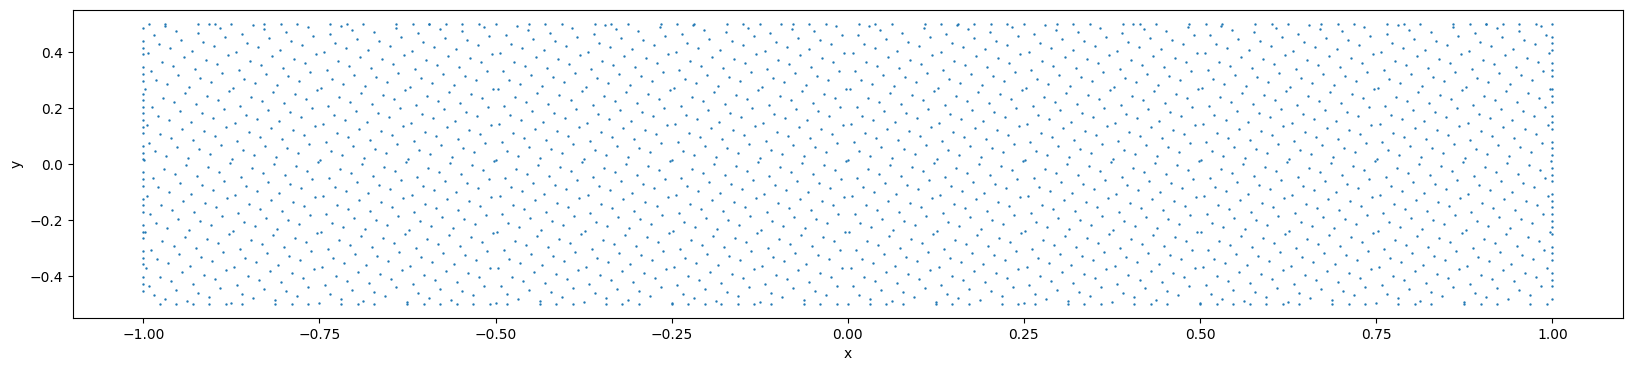

In [9]:
plt.figure(figsize=(20,4))
plt.scatter(data.train_x_all[:,0],data.train_x_all[:,1],s=0.5)
plt.xlabel("x")
plt.ylabel("y")
plt.show

In [13]:
net = dde.maps.FNN([2]+[64]*5+[3], "tanh","Glorot uniform")
model.compile("adam", lr=1e-3)
losshistory,train_state = model.train(epochs = 10000, display_every=100)

Compiling model...
'compile' took 0.000625 s



Training model...

Step      Train loss                                                                                    Test loss                                                                                     Test metric
10000     [1.23e-03, 3.05e-04, 2.33e-03, 1.50e-02, 5.70e-03, 1.46e-02, 5.26e-03, 1.49e-05, 4.82e-06]    [7.22e-04, 2.12e-04, 8.78e-04, 1.50e-02, 5.70e-03, 1.46e-02, 5.26e-03, 1.49e-05, 4.82e-06]    []  
10100     [1.50e-03, 8.26e-04, 2.99e-03, 2.10e-02, 2.58e-03, 4.35e-02, 8.71e-04, 1.42e-04, 3.49e-05]    [7.35e-04, 5.14e-04, 2.37e-03, 2.10e-02, 2.58e-03, 4.35e-02, 8.71e-04, 1.42e-04, 3.49e-05]    []  
10200     [1.18e-03, 6.83e-04, 2.05e-03, 1.88e-02, 3.29e-03, 3.45e-02, 1.28e-03, 4.14e-05, 6.51e-05]    [6.22e-04, 3.91e-04, 1.30e-03, 1.88e-02, 3.29e-03, 3.45e-02, 1.28e-03, 4.14e-05, 6.51e-05]    []  
10300     [1.08e-03, 5.56e-04, 2.27e-03, 1.90e-02, 3.84e-03, 2.40e-02, 1.89e-03, 1.16e-05, 2.11e-05]    [6.16e-04, 2.30e-04, 1.21e-03, 1.90e-02, 3.84e-03, 2.40e-0

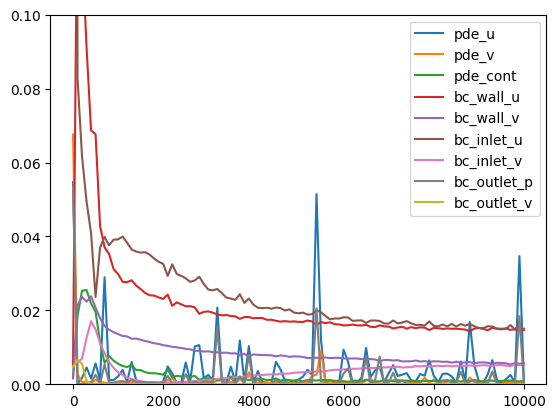

In [11]:
plot_array = np.array(losshistory.loss_test)
plot_labels = ["pde_u", "pde_v", "pde_cont", "bc_wall_u","bc_wall_v","bc_inlet_u","bc_inlet_v","bc_outlet_p","bc_outlet_v"]
# plot_array = np.array(losshistory.loss_train)
for i in range(plot_array.shape[1]):
    plt.plot(losshistory.steps, plot_array[:,i], label=plot_labels[i])
    
plt.legend()
plt.ylim([0, 0.1])
plt.show()

In [14]:
dde.optimizers.config.set_LBFGS_options(maxiter=3000)
model.compile("L-BFGS")
losshistory,train_state = model.train()
dde.saveplot(losshistory, train_state, issave = False , isplot = False)

Compiling model...
'compile' took 0.528715 s

Training model...

Step      Train loss                                                                                    Test loss                                                                                     Test metric
20000     [2.54e-03, 7.58e-04, 1.98e-03, 1.37e-02, 4.28e-03, 1.18e-02, 5.62e-03, 1.02e-03, 1.02e-05]    [1.83e-03, 6.82e-04, 8.72e-04, 1.37e-02, 4.28e-03, 1.18e-02, 5.62e-03, 1.02e-03, 1.02e-05]    []  
23000     [3.30e-04, 3.55e-04, 4.92e-04, 2.67e-03, 7.64e-04, 2.38e-03, 8.22e-04, 7.65e-06, 2.76e-06]    [1.74e-04, 1.27e-04, 9.34e-05, 2.67e-03, 7.64e-04, 2.38e-03, 8.22e-04, 7.65e-06, 2.76e-06]    []  

Best model at step 23000:
  train loss: 7.82e-03
  test loss: 7.04e-03
  test metric: []

'train' took 2340.214565 s



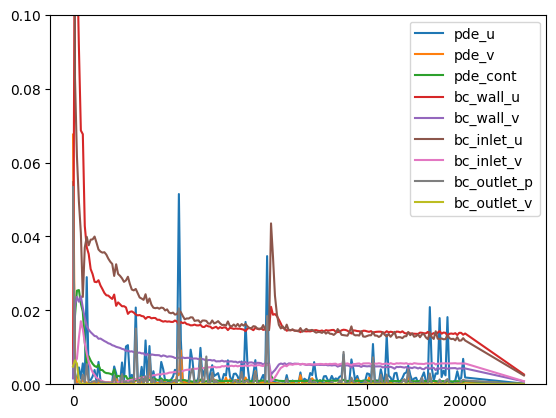

In [15]:
plot_array = np.array(losshistory.loss_test)
plot_labels = ["pde_u", "pde_v", "pde_cont", "bc_wall_u","bc_wall_v","bc_inlet_u","bc_inlet_v","bc_outlet_p","bc_outlet_v"]
# plot_array = np.array(losshistory.loss_train)
for i in range(plot_array.shape[1]):
    plt.plot(losshistory.steps, plot_array[:,i], label=plot_labels[i])
    
plt.legend()
plt.ylim([0, 0.1])
plt.show()

In [16]:
samples= geom.random_points(500000)
result = model.predict(samples)

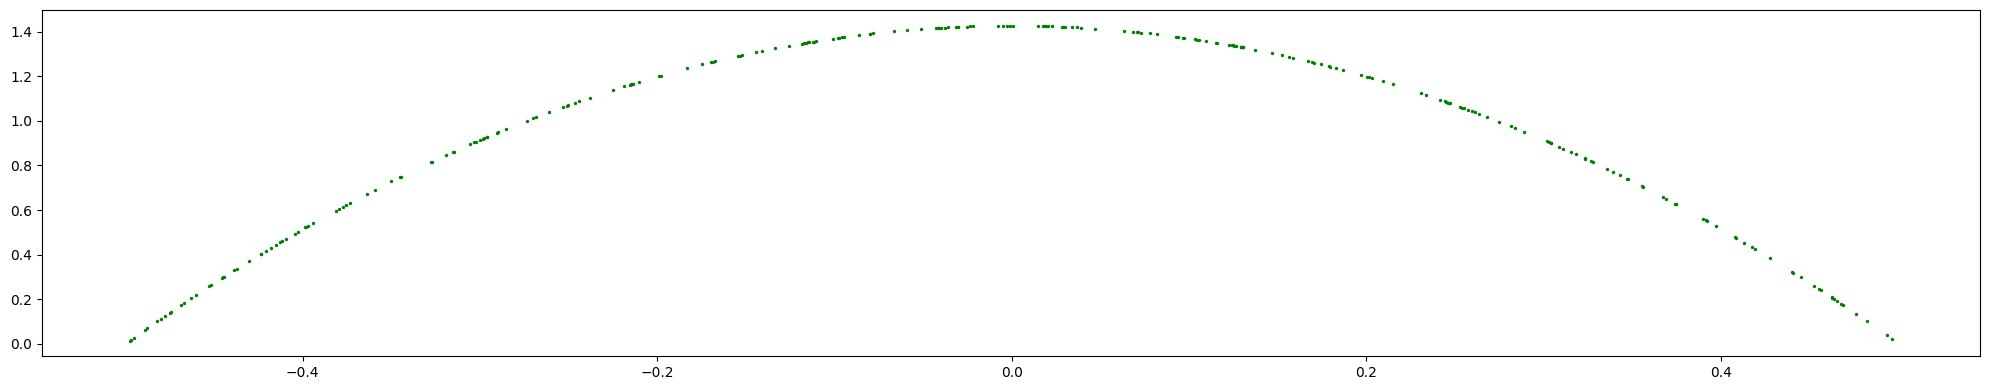

In [17]:
color_legend=[[0,1.5],[-0.3,0.3],[0,35]]
# for idx in range(3):
plt.figure(figsize=(20,4))
mask = np.where((samples[:,0] > (D/2 - 0.001)) & (samples[:,0] <= D/2))
plt.scatter(samples[mask,1], result[mask,0], c='green',s=2)
mask = np.where((samples[:,0] < -(D/2 + 0.001)) & (samples[:,0] >= -D/2))
plt.scatter(samples[mask,1], result[mask,0], c='red',s=2)
plt.tight_layout()
plt.show()

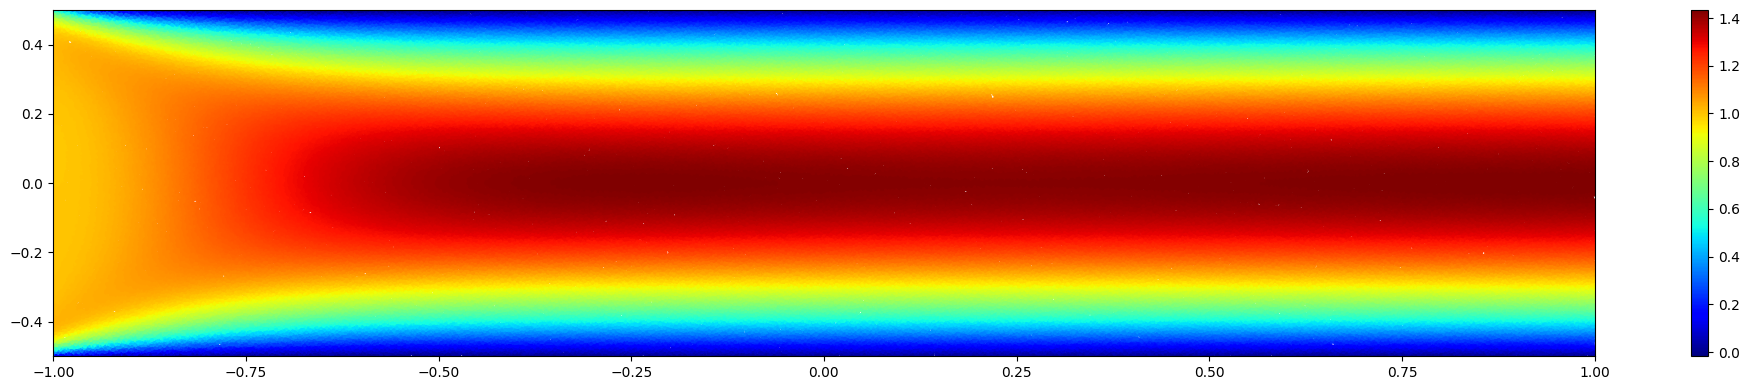

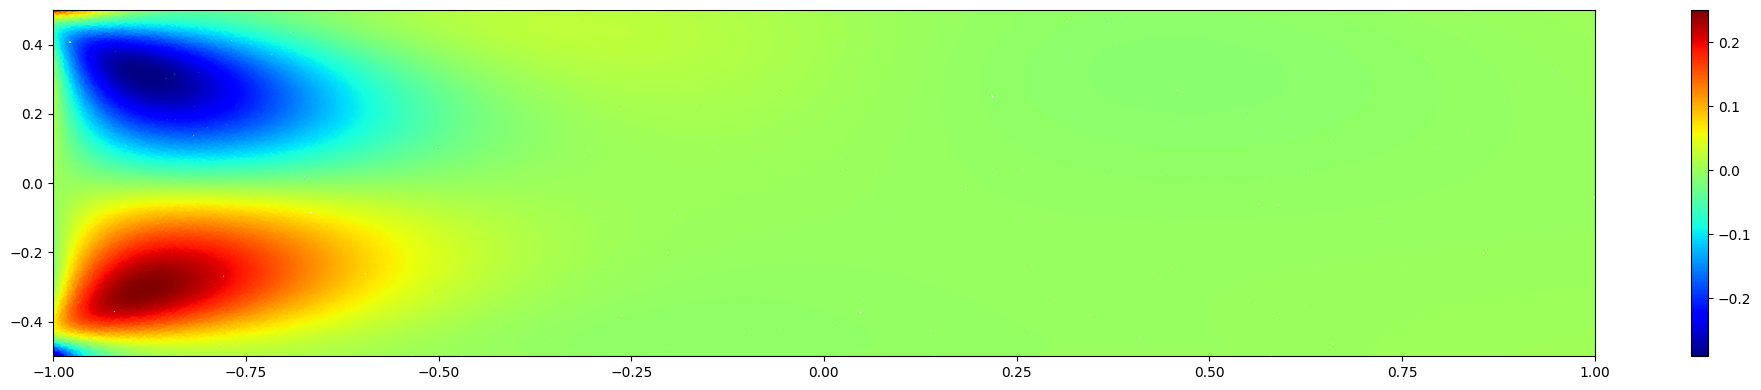

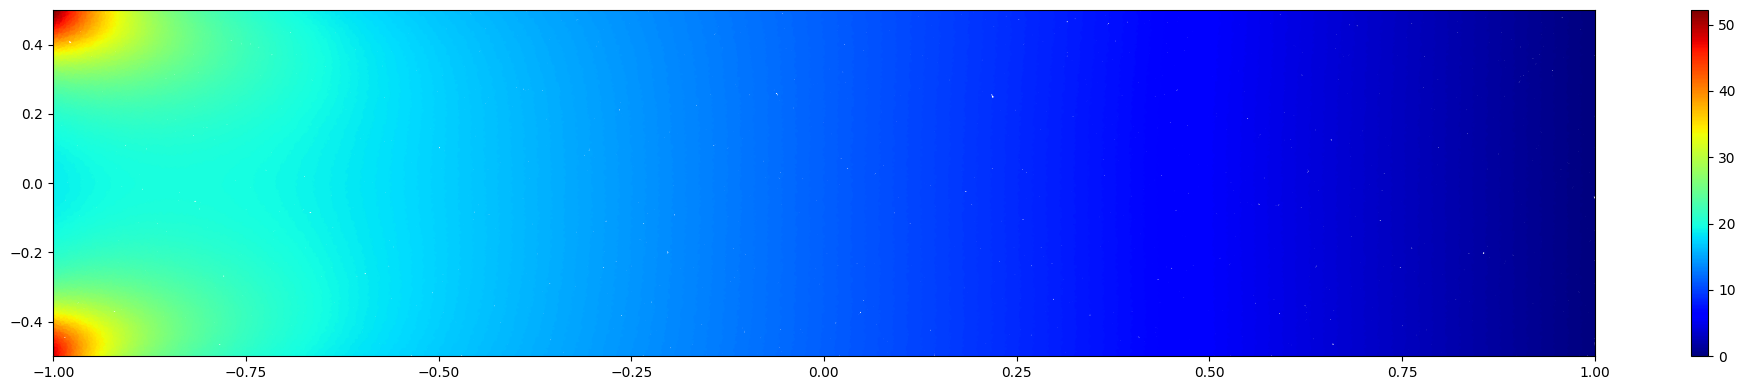

In [18]:
color_legend = [[0,1.5],[-0.3,0.3],[0,35]]

for idx in range(3):
    plt.figure(figsize=(20,4))
    plt.scatter(samples[:,0],
               samples[:,1],
               c = result[:,idx],
               cmap= 'jet',
               s=2)
    plt.colorbar()
    plt.clim([result[:,idx].min(), result[:,idx].max()])
    plt.xlim((0-L/2, L-L/2))
    plt.ylim((0-D/2, D-D/2))
    plt.tight_layout()
    plt.show()

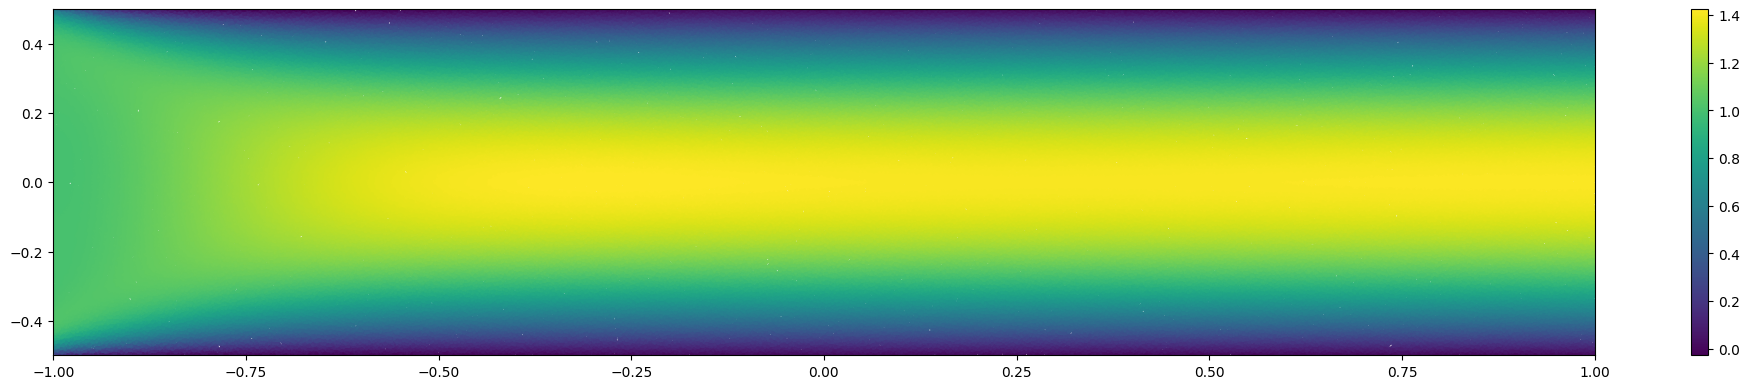

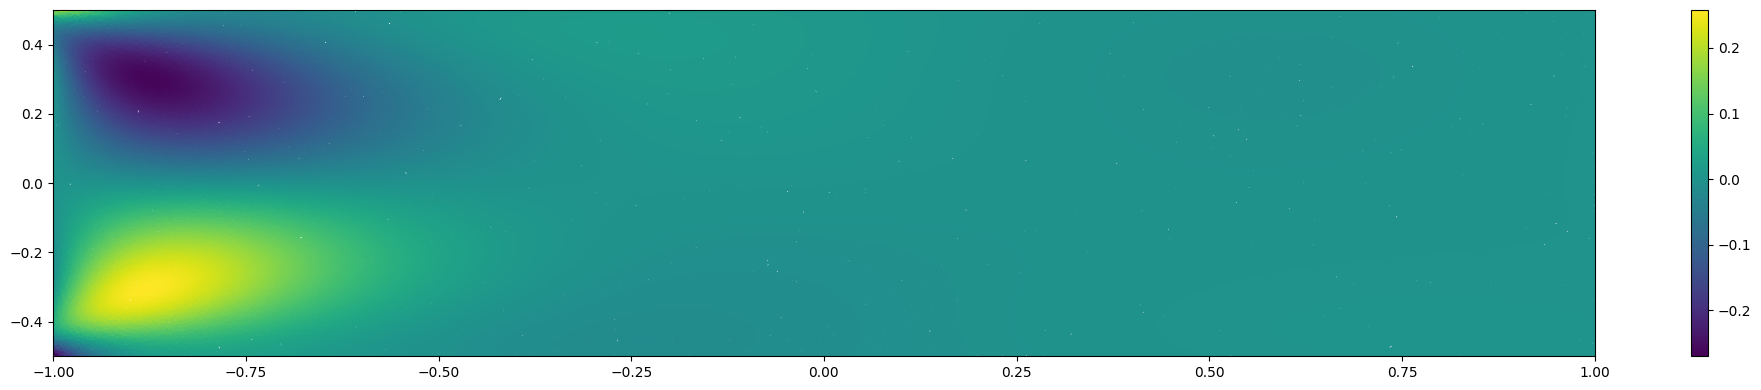

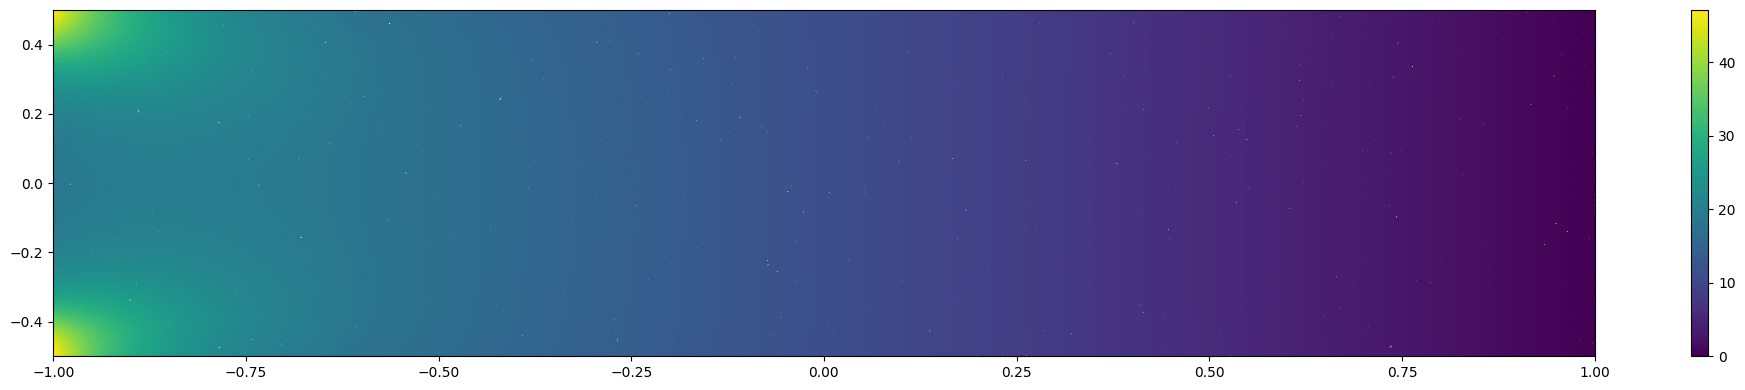

In [ ]:
color_legend = [[0,1.5],[-0.3,0.3],[0,35]]

for idx in range(3):
    plt.figure(figsize=(20,4))
    plt.scatter(samples[:,0],
               samples[:,1],
               c = result[:,idx],
               cmap= 'viridis',
               s=2)
    plt.colorbar()
    plt.clim([result[:,idx].min(), result[:,idx].max()])
    plt.xlim((0-L/2, L-L/2))
    plt.ylim((0-D/2, D-D/2))
    plt.tight_layout()
    plt.show()

# Analytical solution